In [1]:
import os
import logging
import sys
from contextlib import contextmanager
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
# @contextmanager
# def suppress_output():
#     with open(os.devnull, 'w') as fnull:
#         old_stdout = sys.stdout
#         old_stderr = sys.stderr
#         sys.stdout = fnull
#         sys.stderr = fnull
#         try:
#             yield
#         finally:
#             sys.stdout = old_stdout
#             sys.stderr = old_stderr


In [3]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("training.log"),  
    ]
)
logger = logging.getLogger(__name__)

In [4]:
import torch
import numpy as np
from torch.utils.data import Subset, DataLoader
from tqdm.auto import tqdm
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, TrainingArguments, AutoModelForCausalLM
from mamba_trainer.data import DataModule
from mamba_trainer.trainer import MambaTrainer, GradientCallback
%matplotlib inline 

/home/sapr7y/noisy_ssm/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-02 21:17:45.630384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 21:17:45.650534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 21:17:45.656915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 21:17:45.673492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binar

In [5]:
model = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-130m-hf")
tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
tokenizer.eos_token = "<|endoftext|>"
tokenizer.pad_token = tokenizer.eos_token

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

lora_config = LoraConfig(
    r=16,
    target_modules=["x_proj", "embeddings", "in_proj", "out_proj"],
    task_type="CAUSAL_LM",
    bias="none"
)

model = get_peft_model(model, lora_config)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MambaForCausalLM(
      (backbone): MambaModel(
        (embeddings): lora.Embedding(
          (base_layer): Embedding(50280, 768)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict()
          (lora_B): ModuleDict()
          (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 16x50280 (cuda:0)])
          (lora_embedding_B): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 768x16 (cuda:0)])
          (lora_magnitude_vector): ModuleDict()
        )
        (layers): ModuleList(
          (0-23): 24 x MambaBlock(
            (norm): MambaRMSNorm(768, eps=1e-05)
            (mixer): MambaMixer(
              (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
              (act): SiLU()
              (in_proj): lora.Linear(
                (base_la

In [7]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

print_trainable_parameters(model)

trainable params: 3,796,608 || all params: 132,931,968 || trainable%: 2.86


In [8]:
training_args = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    output_dir="model",
    logging_dir="logs",
    evaluation_strategy="no", 
    logging_steps=1,
    save_steps=1,
    report_to="none",
    disable_tqdm=True,
)

/home/sapr7y/noisy_ssm/.venv/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
train_data_module = DataModule(data_path="./data/basic_50-150/train.tsv", tokenizer=tokenizer)
train_dataset = train_data_module.dataset
val_data_module = DataModule(data_path="./data/basic_50-150/val.tsv", tokenizer=tokenizer)
val_dataset = val_data_module.dataset

./data/basic_50-150/train.tsv


I0000 00:00:1725301074.160989 3167098 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725301074.165349 3167098 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725301074.167017 3167098 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725301074.205443 3167098 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

./data/basic_50-150/val.tsv


2024-09-02 21:18:04.077800: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def evaluate(trainer, eval_dataset, step):
    metrics = trainer.evaluate(eval_dataset)
    loss = metrics.get('eval_loss', None)
    logger.info(f"Validation Loss at step {step}: {loss}")

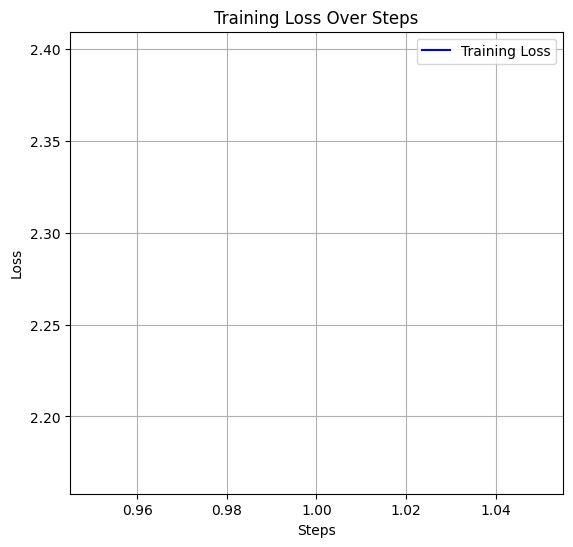

  0%|          | 1/1000 [00:01<30:44,  1.85s/it]

{'train_runtime': 1.235, 'train_samples_per_second': 3.239, 'train_steps_per_second': 0.81, 'train_loss': 2.2836382389068604, 'epoch': 1.0}


  0%|          | 1/1000 [00:02<41:05,  2.47s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB. GPU 0 has a total capacty of 79.26 GiB of which 104.75 MiB is free. Including non-PyTorch memory, this process has 79.14 GiB memory in use. Of the allocated memory 1.72 GiB is allocated by PyTorch, and 132.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
grad_callback = GradientCallback()
norms = []

for i in tqdm(range(1000), disable=False):
    np.random.seed(None)
    ids = np.random.choice(len(train_dataset), size=4, replace=False)
    subset = Subset(train_dataset, ids.tolist())
    
    trainer = MambaTrainer(
            model=model,
            args=training_args,
            train_dataset=subset,
            tokenizer=tokenizer,
            optimizers=(optimizer, None),
            data_collator=train_data_module.data_collator,
            callbacks=[grad_callback]
        )

    trainer.train()


    norms.append(torch.linalg.norm(grad_callback.gradients))

    if grad_callback.step % 20 == 0:
        evaluate(trainer=trainer,
                     eval_dataset=val_dataset,
                     step=grad_callback.step
        )